### Установка и импорт

In [ ]:
!pip install transformers
!pip install wandb
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 39.3 MB/s 
     |████████████████████████████████| 101 kB 10.9 MB/s 
     |████████████████████████████████| 6.6 MB 38.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.0 MB/s 
     |████████████████████████████████| 181 kB 46.5 MB/s 
     |████████████████████████████████| 146 kB 44.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=436f659612fd4ce7c846dca7169468800324f5f0b19c021f1e247e2b4a6cc85b
  Stored in directory: /root/.cache/pi

In [ ]:
!gdown 1QYkFiLnSS6HFrJ9VePIudOCrgtOUk7F0
!gdown 1N3VnKzeSIWMC2F2VK33xoFsC1tu234rz

Downloading...
From: https://drive.google.com/uc?id=1QYkFiLnSS6HFrJ9VePIudOCrgtOUk7F0
To: /content/data_train[493].csv
100% 3.87M/3.87M [00:00<00:00, 129MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N3VnKzeSIWMC2F2VK33xoFsC1tu234rz
To: /content/data_test_public[494].csv
100% 476k/476k [00:00<00:00, 118MB/s]


In [ ]:
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel, BertForSequenceClassification
import torch
import numpy as np
from transformers import BertTokenizer
from tqdm import tqdm
import pandas as pd
import wandb
from IPython.display import clear_output
import gc

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Bert с линейной сверткой на выходе

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, bert_name, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(bert_name)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
bert_name = 'DeepPavlov/rubert-base-cased-conversational'

tokenizer = BertTokenizer.from_pretrained(bert_name)


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df, max_length):

        self.labels = [label for label in df['toxic']]
        self.texts = [tokenizer(text, padding='max_length', max_length = max_length,
                                truncation=True, return_tensors="pt") for text in df['comment']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [ ]:
type(BertClassifier(bert_name))

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


__main__.BertClassifier

### Подготовка датафреймов

In [ ]:
df_train = pd.read_csv('./data_train[493].csv', index_col=0)
df_test = pd.read_csv('./data_test_public[494].csv', index_col=0)

In [ ]:
df_test = df_test.replace(' ', np.NaN).dropna()
df_train = df_train.replace(' ', np.NaN).dropna()

In [ ]:
df_train["toxic"] = df_train["toxic"].astype(int)
df_train["comment"] = df_train["comment"].astype(str)
df_test["toxic"] = df_test["toxic"].astype(int) 
df_test["comment"] = df_test["comment"].astype(str) 

In [ ]:
df_test.info(), df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442 entries, 14051 to 6769
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  1442 non-null   object
 1   toxic    1442 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11673 entries, 3795 to 8084
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  11673 non-null  object
 1   toxic    11673 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 273.6+ KB


(None, None)

### Анализ датасетов

In [ ]:
df_train["toxic"].value_counts()

0    7764
1    3909
Name: toxic, dtype: int64

In [ ]:
df_test["toxic"].value_counts()

0    959
1    483
Name: toxic, dtype: int64

In [ ]:
def get_tokens(texts, max_length=None):
    tokens = []
    for t in texts:
        bert_input = tokenizer(t, padding='max_length', max_length=max_length,
                               truncation=True, return_tensors="pt")
        tokens.append(bert_input.input_ids[0][np.array(bert_input.input_ids[0]) != 0])
    return tokens

In [ ]:
train_tokens = get_tokens(df_train["comment"])

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
val_tokens = get_tokens(df_test["comment"])

In [ ]:
len(max(train_tokens, key=lambda x: len(x))), len(max(val_tokens, key=lambda x: len(x)))

(1613, 1200)

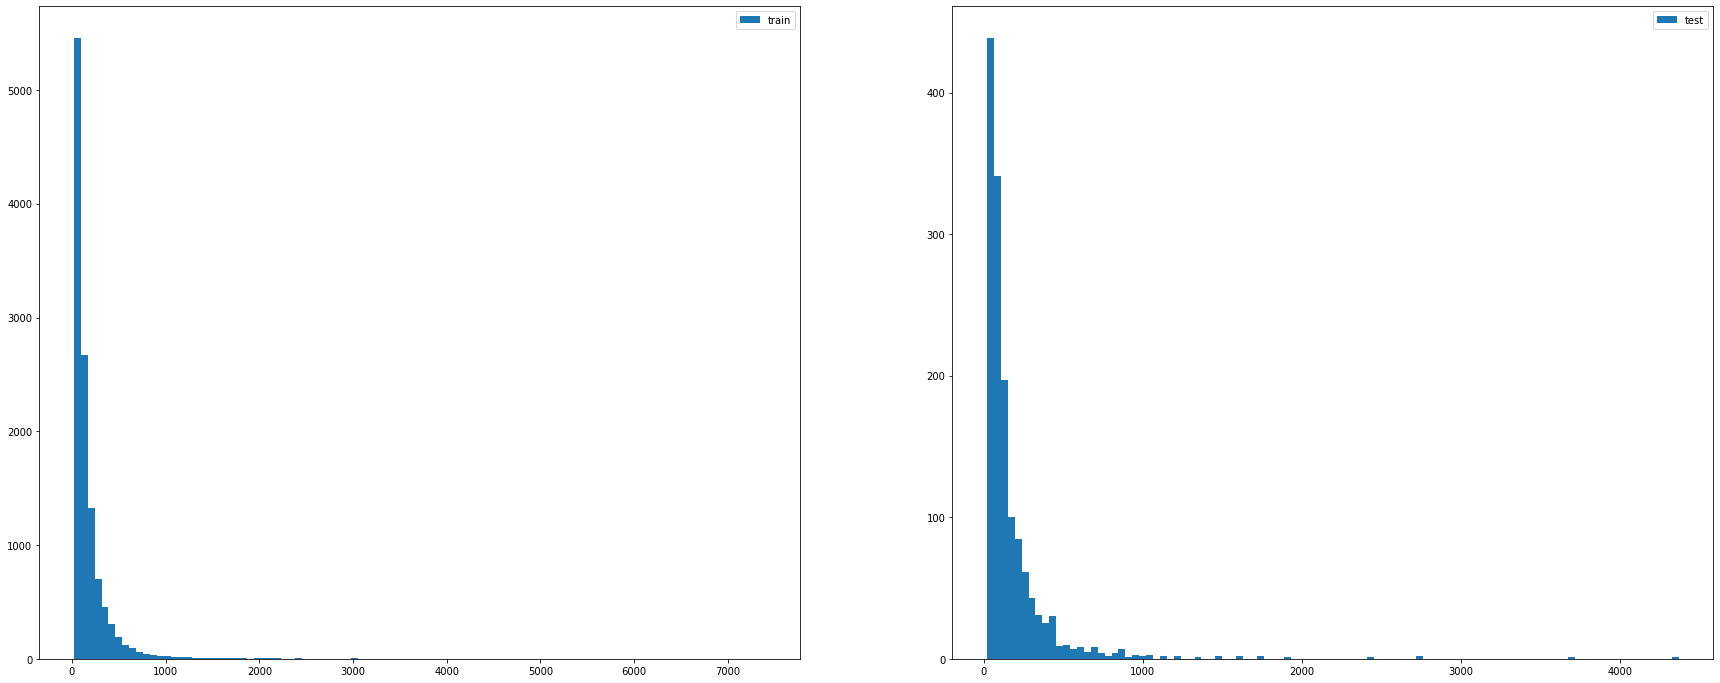

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 12))
plt.subplot(121).hist(df_train["comment"].str.len(), label='train', bins=100)
plt.legend()
plt.subplot(122).hist(df_test["comment"].str.len(), label='test', bins=100)
plt.legend()

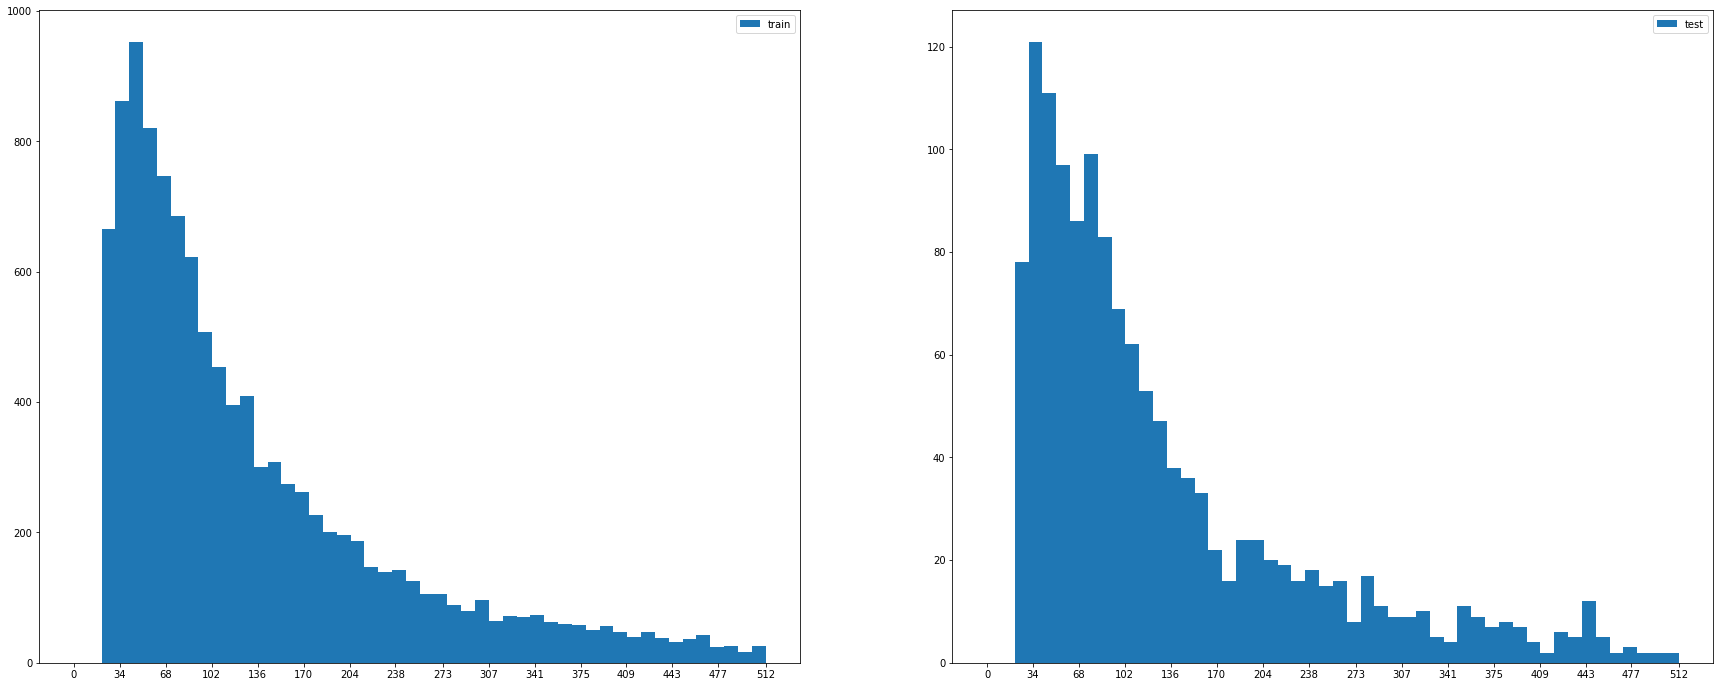

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 12))
plt.subplot(121).hist(df_train["comment"].str.len(), label='train', bins=50, range=(0, 512))
plt.xticks(np.linspace(0, 512, 16, dtype=int))
plt.legend()
plt.subplot(122).hist(df_test["comment"].str.len(), label='test', bins=50, range=(0, 512))
plt.xticks(np.linspace(0, 512, 16, dtype=int))

plt.legend()

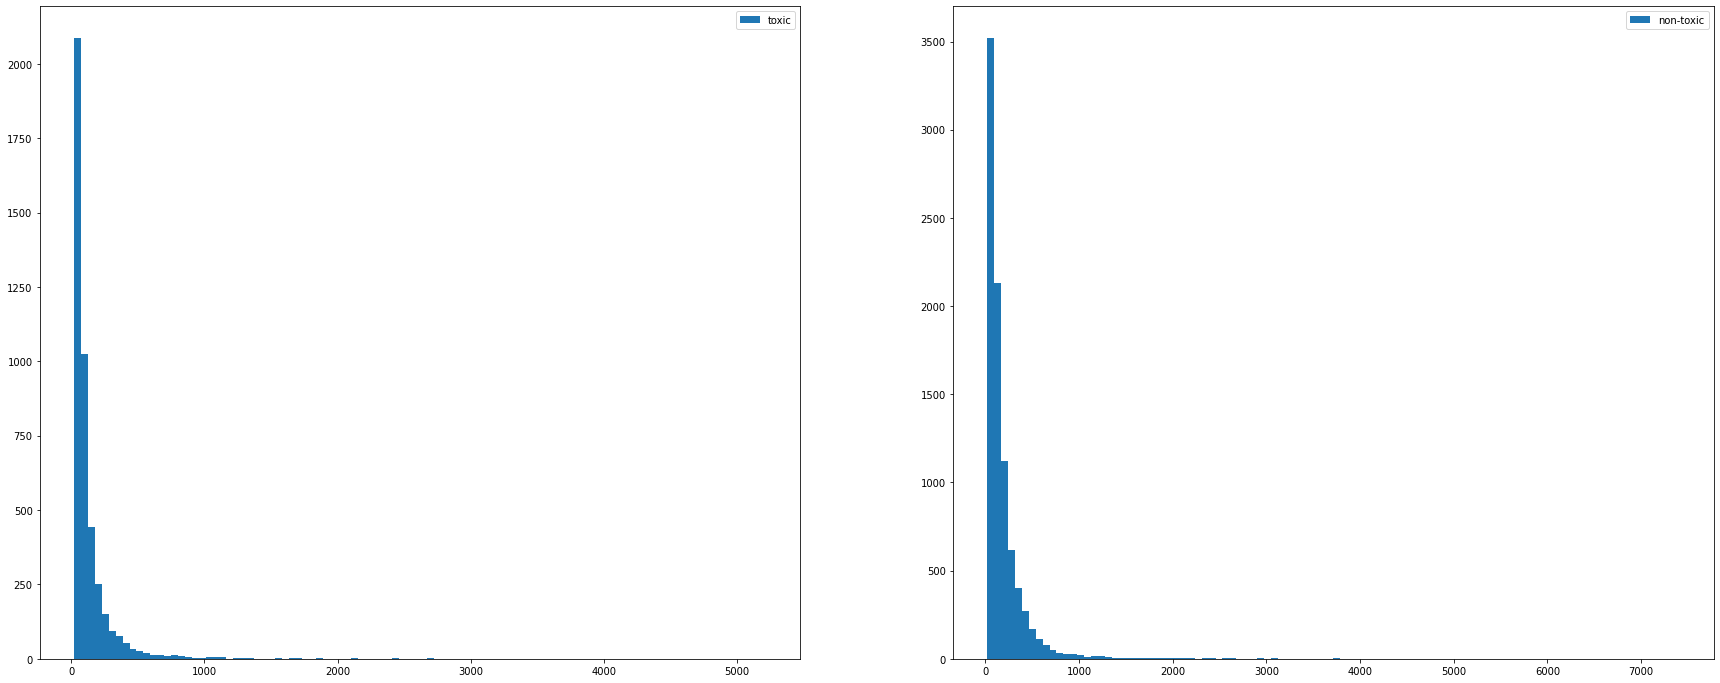

In [ ]:
plt.figure(figsize=(30, 12))
toxic = pd.concat((df_train["comment"][df_train["toxic"] == 1], df_test["comment"][df_test["toxic"] == 1]))
non_toxic = pd.concat((df_train["comment"][df_train["toxic"] == 0], df_test["comment"][df_test["toxic"] == 0]))
plt.subplot(121).hist(toxic.str.len(), label='toxic', bins=100)
plt.legend()
plt.subplot(122).hist(non_toxic.str.len(), label='non-toxic', bins=100)
plt.legend()

In [ ]:
toxic_tokens = get_tokens(toxic)
nontoxic_tokens = get_tokens(non_toxic)

In [ ]:
import pandas as pd

len(pd.DataFrame(columns=['a', 's', 'f']))

0

In [ ]:
toxic_tokens[0]

tensor([  101, 77925,  4170,  4288,   132, 58268,  1527,   840,  1100,   879,
         1722,   128,  1109,  3612,  1035, 32315,   132,   102])

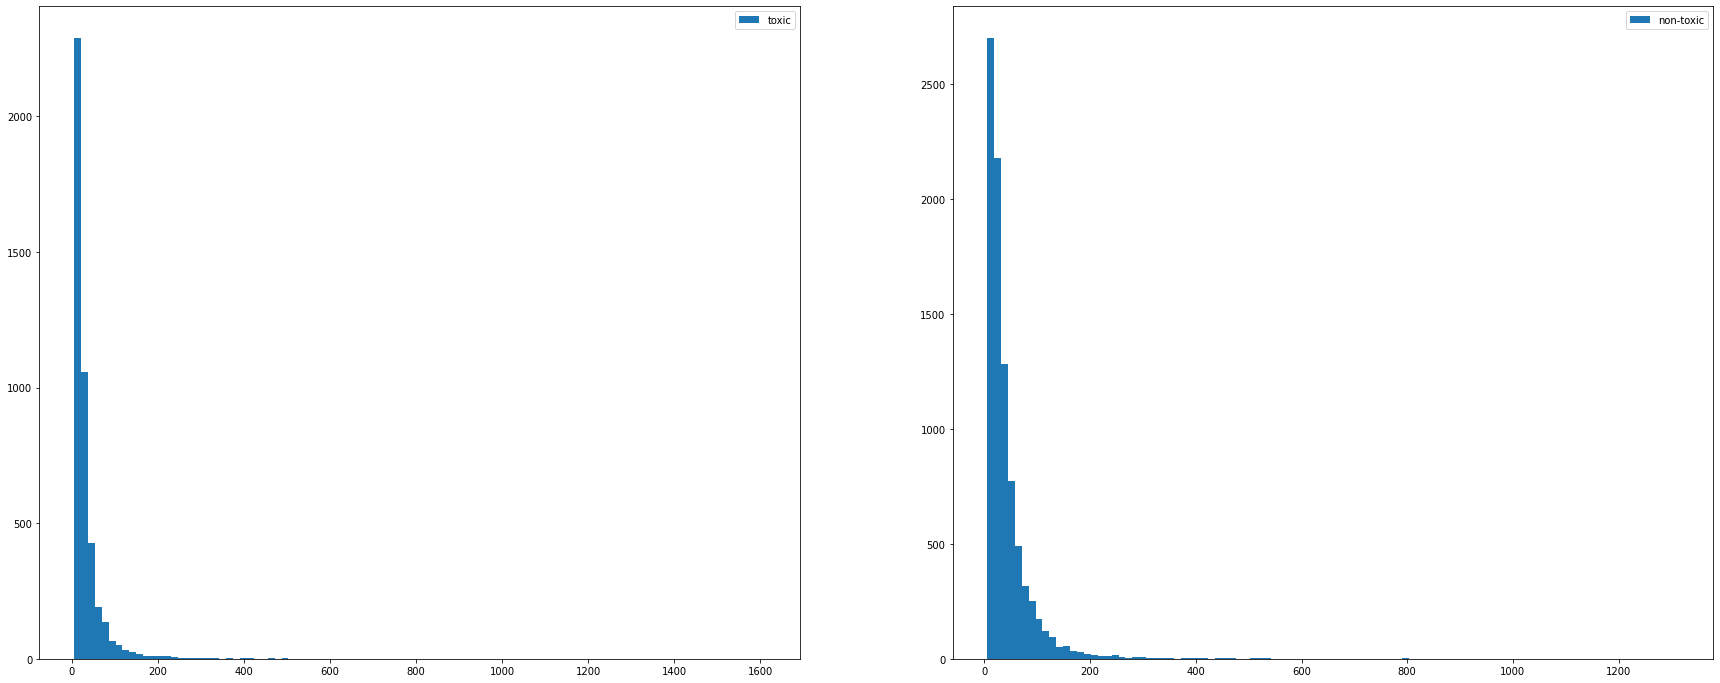

In [ ]:
plt.figure(figsize=(30, 12))
plt.subplot(121).hist(list(map(lambda x: len(x), toxic_tokens)), label='toxic', bins=100)
plt.legend()
plt.subplot(122).hist(list(map(lambda x: len(x), nontoxic_tokens)), label='non-toxic', bins=100)
plt.legend()

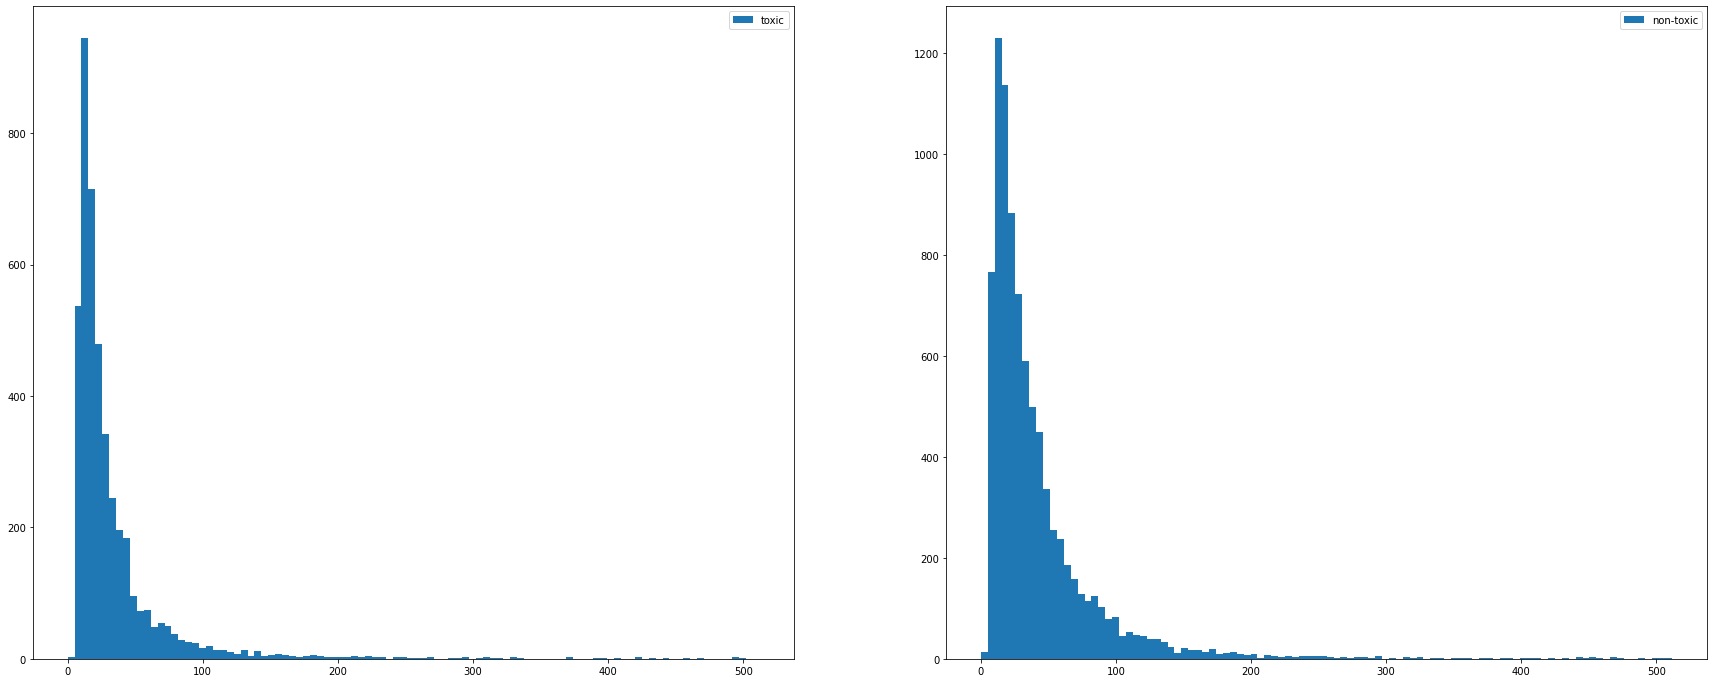

In [ ]:
plt.figure(figsize=(30, 12))
plt.subplot(121).hist(list(map(lambda x: len(x), toxic_tokens)), label='toxic', bins=100, range=(0, 512))
plt.legend()
plt.subplot(122).hist(list(map(lambda x: len(x), nontoxic_tokens)), label='non-toxic', bins=100, range=(0, 512))
plt.legend()

In [ ]:
toxic_tokens_lengths = np.array(list(map(lambda x: len(x), toxic_tokens)))
nontoxic_tokens_lengths = np.array(list(map(lambda x: len(x), nontoxic_tokens)))
len(toxic_tokens_lengths[toxic_tokens_lengths <= 64]) / len(toxic_tokens_lengths), len(nontoxic_tokens_lengths[nontoxic_tokens_lengths <= 64] ) / len(nontoxic_tokens_lengths)

(0.892304189435337, 0.8291872062363865)

In [ ]:
toxic_train_tokens = get_tokens(df_train["comment"][df_train["toxic"] == 1])
nontoxic_train_tokens = get_tokens(df_train["comment"][df_train["toxic"] == 0])

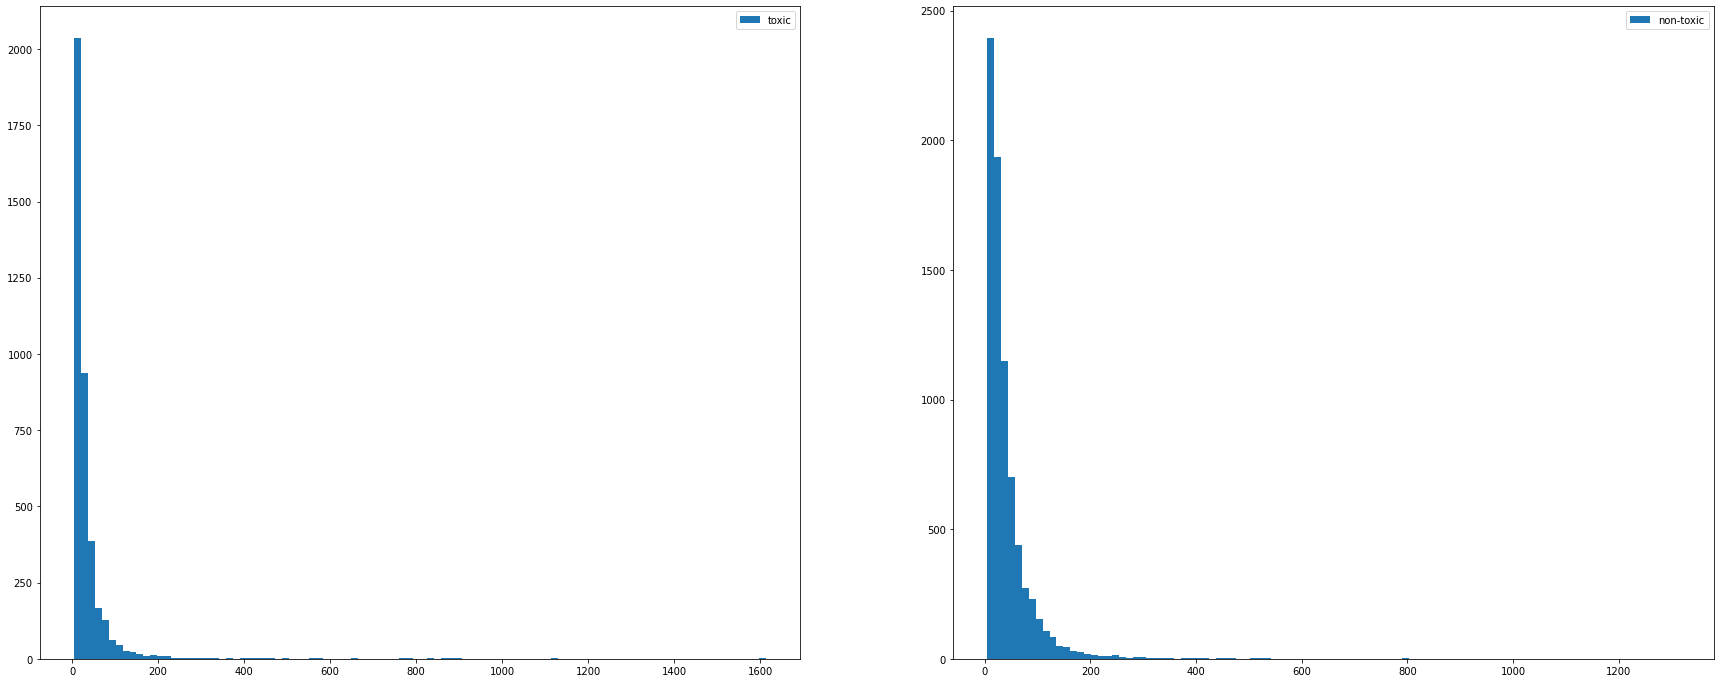

In [ ]:
plt.figure(figsize=(30, 12))
plt.subplot(121).hist(list(map(lambda x: len(x), toxic_train_tokens)), label='toxic', bins=100)
plt.legend()
plt.subplot(122).hist(list(map(lambda x: len(x), nontoxic_train_tokens)), label='non-toxic', bins=100)
plt.legend()

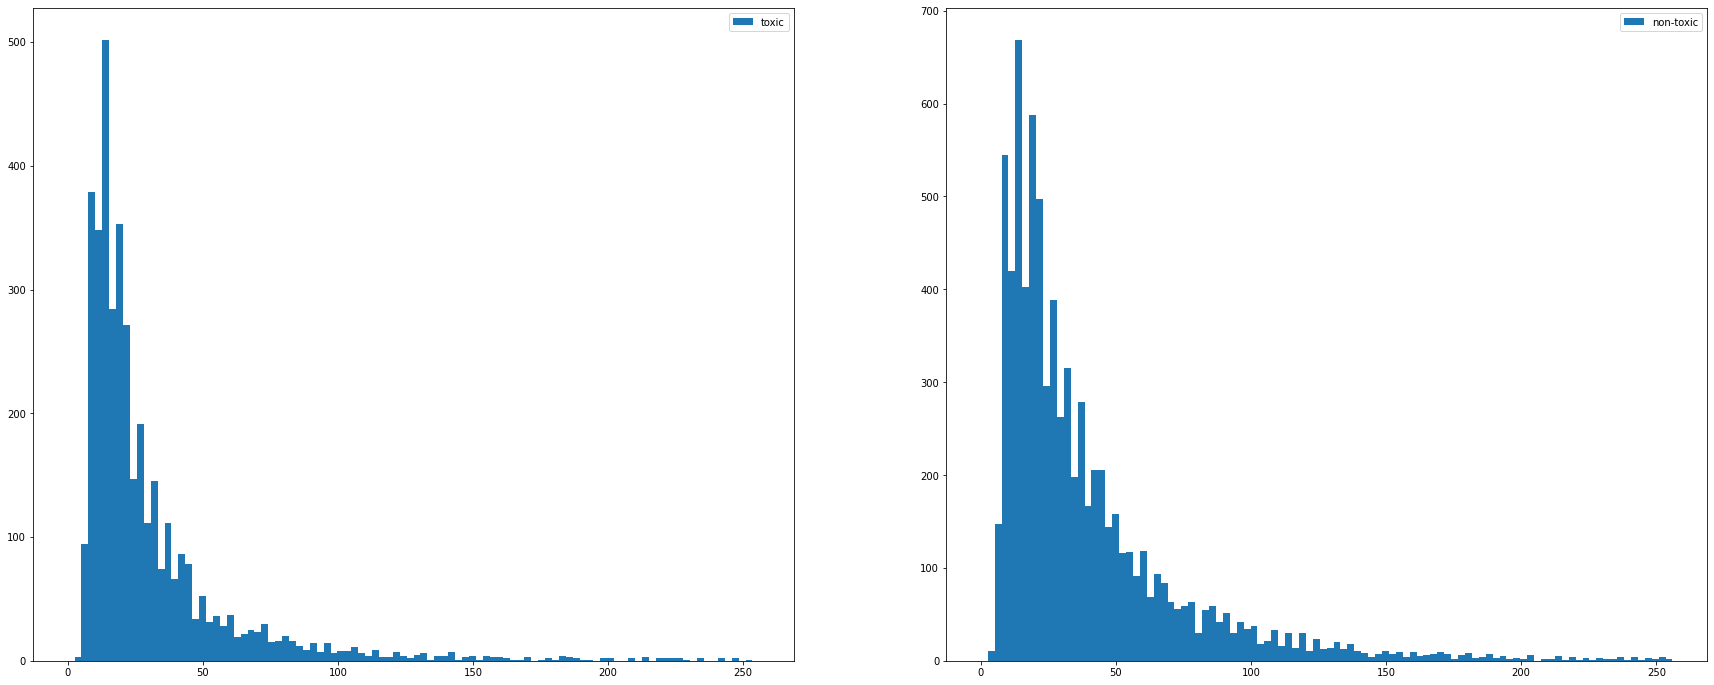

In [ ]:
plt.figure(figsize=(30, 12))
plt.subplot(121).hist(list(map(lambda x: len(x), toxic_train_tokens)), label='toxic', bins=100, range=(0, 256))
plt.legend()
plt.subplot(122).hist(list(map(lambda x: len(x), nontoxic_train_tokens)), label='non-toxic', bins=100, range=(0, 256))
plt.legend()

In [ ]:
def cut_tokens_table(toxic_tokens_lengths, nontoxic_tokens_lengths):
    n_toxic = len(toxic_tokens_lengths)
    cut_tokens_df = pd.DataFrame(columns=['Осталось токсичных(%)', 'Осталось нетоксичных(%)', 'Осталось токсичных(шт)', 'Осталось нетоксичных(шт)', 'Баланс'], index=[8, 16, 32, 64, 128, 256, 512])
    n_nontoxic = len(nontoxic_tokens_lengths)
    n_toxic = len(toxic_tokens_lengths)

    for i in cut_tokens_df.index:
        cut_tokens_df['Осталось токсичных(шт)'][i] = len(toxic_tokens_lengths[toxic_tokens_lengths <= i])    
        cut_tokens_df['Осталось нетоксичных(шт)'][i] = len(nontoxic_tokens_lengths[nontoxic_tokens_lengths <= i])    
        cut_tokens_df['Осталось токсичных(%)'][i] = cut_tokens_df['Осталось токсичных(шт)'][i] / n_toxic * 100
        cut_tokens_df['Осталось нетоксичных(%)'][i] = cut_tokens_df['Осталось нетоксичных(шт)'][i] / n_nontoxic * 100
        cut_tokens_df['Баланс'][i] = cut_tokens_df['Осталось токсичных(шт)'][i] / cut_tokens_df['Осталось нетоксичных(шт)'][i]
    return cut_tokens_df
    #     print(f'{i}:\t{n_toxic / len(toxic_tokens_lengths)}\t{n_nontoxic / len(nontoxic_tokens_lengths)}')    
    #     print(f'\t{len(n_toxic}\t\t\t{n_nontoxic}')
    #     print(f'Balance:\t{})
cut_tokens_table(toxic_tokens_lengths, nontoxic_tokens_lengths)

,Осталось токсичных(%),Осталось нетоксичных(%),Осталось токсичных(шт),Осталось нетоксичных(шт),Баланс
8,4.758652,3.932133,209,343,0.609329
16,37.682149,25.667775,1655,2239,0.739169
32,71.721311,57.377049,3150,5005,0.629371
64,89.230419,82.918721,3919,7233,0.541822
128,96.607468,95.529061,4243,8333,0.50918
256,98.97541,99.025565,4347,8638,0.503241
512,99.726776,99.816577,4380,8707,0.503044


In [ ]:
toxic_train_tokens_lengths = np.array(list(map(lambda x: len(x), toxic_train_tokens)))
nontoxic_train_tokens_lengths = np.array(list(map(lambda x: len(x), nontoxic_train_tokens)))
cut_tokens_table(toxic_train_tokens_lengths, nontoxic_train_tokens_lengths)

,Осталось токсичных(%),Осталось нетоксичных(%),Осталось токсичных(шт),Осталось нетоксичных(шт),Баланс
8,4.75825,4.044307,186,314,0.592357
16,37.631108,25.643998,1471,1991,0.738825
32,71.476081,57.199897,2794,4441,0.629138
64,89.153236,82.972694,3485,6442,0.540981
128,96.623177,95.633694,3777,7425,0.508687
256,98.925556,99.034003,3867,7689,0.502926
512,99.718598,99.819681,3898,7750,0.502968


In [ ]:
nontoxic_tokens_lengths = np.array(list(map(lambda x: len(x), toxic_tokens)))
nontoxic_tokens_lengths = np.array(list(map(lambda x: len(x), nontoxic_tokens)))
len(toxic_tokens_lengths <= 128) / len(toxic_tokens_lengths)

1.0

In [ ]:
def balance(df):
    nontoxic_sample = df[df["toxic"] == 0].sample(len(df[df["toxic"] == 1]))
    return pd.concat((df[df["toxic"] == 1], nontoxic_sample))

print(len(df_train[df_train["toxic"] == 1]), len(df_train[df_train["toxic"] == 0]))
balanced_train_df = balance(df_train)
balanced_train_df["comment"] = balanced_train_df["comment"].str.lower()

print(len(balanced_train_df[balanced_train_df["toxic"] == 1]), len(balanced_train_df[balanced_train_df["toxic"] == 0]))

3909 7764
3909 3909


In [ ]:
df_train["comment"] = df_train["comment"].str.lower()
df_test["comment"] = df_test["comment"].str.lower()

In [ ]:
df_train

,comment,toxic
3795,дегенератов везде хватает. маркировать бы их к...,1
4640,почему я не видел в продаже орочьих кружек? ох...,0
7932,напоминает новую машину в минимальной комплект...,0
4184,не узнать его ебанутый говор - это ещё уметь н...,1
1366,я более субъективно оцениваю и на собственном ...,0
...,...,...
10236,"я надеюсь, это постирония. а то на дваче много...",1
3313,"ну, вообще, да. тут уж как повезет. хотя после...",0
7954,где-то сжигают книги.. а где-то фотографов. во...,1
9260,да хоть миллионную биткоина)\n,0


### Обучение BertClassifier

In [ ]:
train = Dataset(df_train, 64)
val = Dataset(df_test, 64)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

In [ ]:



def train(model, loss_fn, opt, scheduler, train_dataloader, val_dataloader, lr, epochs, name, seq_mode=True):
    try:

        name = f'{name}_lr{lr}'.format(lr=lr)

        if os.path.exists(f'./{name}'):
            os.chdir(f'./{name}')
            for f in os.listdir(f'.'):
              os.remove(f)
            os.chdir("..")
        else:
            os.mkdir(f'./{name}')

        run = wandb.init(project='CISM_NLP')
        run.name = name
        log_template = "\nEpoch {ep}/{total_ep} train_loss: {t_loss:0.4f} val_loss: {v_loss:0.4f} train_acc: {t_acc:0.4f} val_acc: {v_acc:0.4f} train_f1_score: {t_f1:0.4f} val_f1_score: {v_f1:0.4f}"
        name_template = "./{name}/e{ep}_loss{loss:0.4f}.h5"
        train_acc, train_loss, val_acc, val_loss, train_f1_score, val_f1_score = [], [], [], [], [], []

        for ep in tqdm(range(epochs)):

            batch_acc, batch_loss, batch_f1_score = [], [], []

            model.train()
            for X_batch, Y_batch in train_dataloader:
#                 print(Y_batch, X_batch)
                Y_batch = Y_batch.to(DEVICE)
                mask = X_batch['attention_mask'].to(DEVICE)
                input_id = X_batch['input_ids'].squeeze(1).to(DEVICE)
                output = model(input_id, mask, return_dict=False)[0] if seq_mode else model(input_id, mask)
                loss = loss_fn(output, Y_batch)
                batch_loss.append(loss.item())
                
                acc = (output.argmax(dim=1) == Y_batch).sum().item() / len(Y_batch)
                batch_acc.append(acc)
                batch_f1_score.append(f1_score(output.argmax(dim=1).cpu().detach(), Y_batch.cpu().detach()))


                model.zero_grad()
                loss.backward()
                opt.step()
                scheduler.step()

            train_acc.append(np.mean(batch_acc))
            train_loss.append(np.mean(batch_loss))
            train_f1_score.append(np.mean(batch_f1_score))

            batch_acc, batch_loss, batch_f1_score = [], [], []
            model.eval()
            with torch.no_grad():

                for X_batch, Y_batch in val_dataloader:

                    Y_batch = Y_batch.to(DEVICE)
                    mask = X_batch['attention_mask'].to(DEVICE)
                    input_id = X_batch['input_ids'].squeeze(1).to(DEVICE)

                    output = model(input_id, mask, return_dict=False)[0] if seq_mode else model(input_id, mask)

                    loss = loss_fn(output, Y_batch)
                        
                    batch_loss.append(loss.item())
                    
                    acc = (output.argmax(dim=1) == Y_batch).sum().item() / len(Y_batch)
                    batch_acc.append(acc)
                    batch_f1_score.append(f1_score(output.argmax(dim=1).cpu().detach(), Y_batch.cpu().detach()))

            val_acc.append(np.mean(batch_acc))
            val_loss.append(np.mean(batch_loss))
            val_f1_score.append(np.mean(batch_f1_score))

            clear_output(wait=True)
            tqdm.write(log_template.format(ep=ep+1, total_ep=epochs, t_loss=train_loss[-1], t_acc=train_acc[-1],
                                           v_loss=val_loss[-1], v_acc=val_acc[-1], t_f1=train_f1_score[-1], v_f1=val_f1_score[-1]))
            fig = plt.figure(figsize=(30, 12))
            loss_ax = fig.add_subplot(131)
            loss_ax.title.set_text('Loss')
            loss_ax.plot([i for i in range(1, len(train_loss) + 1)], train_loss,
                    label = "train")
            loss_ax.plot([i for i in range(1, len(val_loss) + 1)], val_loss, 
                    label = "val")
            loss_ax.legend()
            acc_ax = fig.add_subplot(132)
            acc_ax.title.set_text('Accuracy')
            acc_ax.plot([i for i in range(1, len(train_acc) + 1)], train_acc,
                    label = "train")
            acc_ax.plot([i for i in range(1, len(val_acc) + 1)], val_acc, 
                    label = "val")
            acc_ax.legend()
            f1_ax = fig.add_subplot(133)
            f1_ax.title.set_text('F1 Score')
            f1_ax.plot([i for i in range(1, len(train_f1_score) + 1)], train_f1_score,
                    label = "train")
            f1_ax.plot([i for i in range(1, len(val_f1_score) + 1)], val_f1_score, 
                    label = "val")
            f1_ax.legend()
            plt.show()
            run.log({'train_loss': train_loss[-1], 'val_loss': val_loss[-1],
                    'train_acc': train_acc[-1], 'val_acc': val_acc[-1],
                    'train_f1_score': train_f1_score[-1], 'val_f1_score': val_f1_score[-1]})
            if val_loss[-1] == min(val_loss):
                model_name = name_template.format(name=name, ep=ep+1, loss=val_loss[-1])
                torch.save(model, model_name)
    except (Exception, KeyboardInterrupt) as e:
        print(traceback.format_exc())
    finally:
        run.log_artifact(f'./{name}', name=f'{name}_lr{lr}', 
                         type='model') 
        run.finish(quiet=True)
        # return model
        return torch.load(model_name)

In [ ]:
try:
    torch.cuda.empty_cache()
    gc.collect()
except Exception as e:
    print(e)
model = BertClassifier(bert_name)
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=5*1e-6)
model = train(model, criterion, optimizer, train_dataloader, val_dataloader, 1e-5, 4, bert_name.replace('/', '-'))

### F1 score

In [ ]:
def f1_score(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    tp = (y_pred & y_true).sum()
    tn = (np.logical_not(y_pred) & np.logical_not(y_true)).sum()
    fn = (y_pred & np.logical_not(y_true)).sum()
    fp = (np.logical_not(y_pred) & y_true).sum()
#     print(tp, tn, fn, fp)
    if 0 in (tp, tp+fp, tp+fn):
        return 0 #(y_pred == y_true).sum() / len(y_pred)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    return 2 * precision * recall / (precision + recall)

### Обучение BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    bert_name, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassi

In [ ]:
type(model)[]

transformers.models.bert.modeling_bert.BertForSequenceClassification

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import Adam
import torch.nn as nn
import os
import glob
import traceback


try:
    torch.cuda.empty_cache()
    gc.collect()
except Exception as e:
    print(e)
model = BertForSequenceClassification.from_pretrained(
    bert_name, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
criterion = nn.CrossEntropyLoss()    
model.cuda()
optimizer = Adam(model.parameters(), lr=5e-6)
model = train(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, lr, 4, f"{bert_name.replace('/', '-')}_seq_token64", )

In [ ]:
try:
    torch.cuda.empty_cache()
    gc.collect()
except Exception as e:
    print(e)
model = BertClassifier('bert-base-uncased').to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=5*1e-6)
model = train(model, criterion, optimizer, train_dataloader, val_dataloader, lr, 4)

### Проверка работоспособности f1 score

In [ ]:
import sklearn.metrics as sk_m
import numpy as np

for i in range(100):
    a = np.random.randint(low=0, high=2, size=4)
    b = np.random.randint(low=0, high=2, size=4)
#     if sk_m.f1_score(a, b) != f1_score(a, b):
#         print(sk_m.f1_score(a, b))
    print(f'a={a}, b={b}: sklearn.metrics.f1_score = {sk_m.f1_score(a, b):0.4f}\t f1_score = {f1_score(a, b):0.4f}\t {sk_m.f1_score(a, b) == f1_score(a, b)}')
a, b